## Imports and Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs

SEED = 321
np.random.seed(SEED)

plt.rcParams['figure.facecolor']='white'
plt.rcParams['figure.figsize']=(12,4)
sns.set_context('talk', font_scale=0.9)

In [2]:
def format_xdates(ax, fig=None, xtick_fontweight='bold',
               title= None):
    """Formats x-axis with minor ticks every 3 months, and major 
    ticks every year. Includes different grid options for visibility"""
    # create the locator to place ticks every 3 months.
    loc_3months = mdates.MonthLocator(interval=3)
    fmt_months = mdates.DateFormatter("%b")
    ## for major year ticks
    loc_year = mdates.YearLocator()
    fmt_year = mdates.DateFormatter("%Y")
    
    ## Change the font of the major ticks to stand out
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), 
                       fontweight=xtick_fontweight) 
    
    ## customize minor ticks
    ax.xaxis.set_minor_locator(loc_3months)
    ax.xaxis.set_minor_formatter(fmt_months)
    ## customize major ticks
    ax.xaxis.set_major_locator(loc_year)
    ax.xaxis.set_major_formatter(fmt_year)
    ## Making major/minor gridlines visually distince
    ax.grid(which='minor',axis='x',ls=":")
    ax.grid(which='major',axis='x',color='k')
    if fig is None:
        fig = ax.get_figure()
    ## rotate the dates
    fig.autofmt_xdate(which='major',rotation=90,ha='center')
    return fig,ax

In [28]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)
    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)
    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")
    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)
    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

In [3]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQN3Ksa9szQuO4G1-msXWAp17KtVHQCBnuEieu_auu1wSiBf3-krHusIx5VBMkihxj-KZLBosDIGEyR/pub?output=csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22467 entries, 0 to 22466
Columns: 281 entries, RegionID to 2022-09-30
dtypes: float64(273), int64(2), object(6)
memory usage: 48.2+ MB


,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,114794.0,114975.0,...,269323.0,274032.0,278464.0,284127.0,289739.0,294776.0,297727.0,298796.0,299124.0,298951.0


## Filtering for the 4 Largest Cities

In [4]:
topFour = df.loc[df['SizeRank'] <= 3]
topFour

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0


## Melt the Wide Form Data

In [5]:
# Drop the unnecessary columns before calling melt
topFour_dropped = topFour.drop(columns=['RegionID', 'RegionType', 'StateName'])
meltDF = topFour_dropped.melt(id_vars=['SizeRank', 'RegionName', 'State', 'Metro', 'CountyName'],
                              value_name='Price', var_name='Date')

## Setting Date to index

In [7]:
meltDF['Date'] = pd.to_datetime(meltDF['Date'])
meltDF = meltDF.set_index('Date')
meltDF.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1092 entries, 2000-01-31 to 2022-09-30
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SizeRank    1092 non-null   int64  
 1   RegionName  1092 non-null   object 
 2   State       1092 non-null   object 
 3   Metro       1092 non-null   object 
 4   CountyName  1092 non-null   object 
 5   Price       1087 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 59.7+ KB


In [8]:
meltDF.head()

,SizeRank,RegionName,State,Metro,CountyName,Price
Date,,,,,,
2000-01-31,0,New York,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0
2000-01-31,1,Los Angeles,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0
2000-01-31,2,Houston,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0
2000-01-31,3,Chicago,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0
2000-02-29,0,New York,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,255517.0


## Resample to Monthly data by City

In [9]:
tsDF = meltDF.groupby('RegionName').resample('M').first()

# Visualizing the Data

In [10]:
top = topFour['RegionName']
top

0       New York
1    Los Angeles
2        Houston
3        Chicago
Name: RegionName, dtype: object

In [11]:
plot = tsDF.unstack(level=0)['Price'][top]

def thousands_formatter(x,pos):
    return f'{int(x/1000)}K'

thousFmt = mticks.FuncFormatter(thousands_formatter)

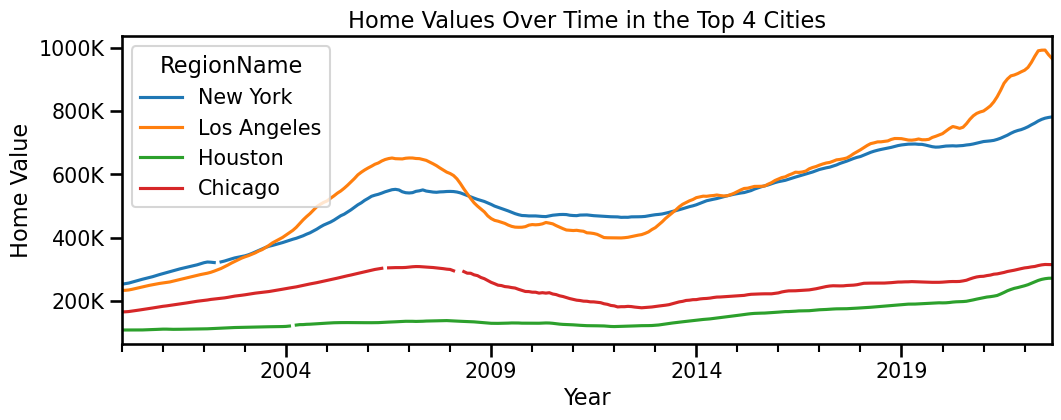

In [12]:
plot.plot()
plt.title('Home Values Over Time in the Top 4 Cities')
plt.xlabel('Year')
plt.ylabel('Home Value')
plt.gca().yaxis.set_major_formatter(thousFmt);

# Find City with Highest and Lowest Value at end of 2008

In [13]:
highValue = tsDF.loc[pd.IndexSlice[:,'12/2008'],:].sort_values('SizeRank')
highValue

,,SizeRank,RegionName,State,Metro,CountyName,Price
RegionName,Date,,,,,,
New York,2008-12-31,0,New York,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,510309.0
Los Angeles,2008-12-31,1,Los Angeles,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,469294.0
Houston,2008-12-31,2,Houston,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,131283.0
Chicago,2008-12-31,3,Chicago,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,265306.0


<Axes: ylabel='RegionName'>

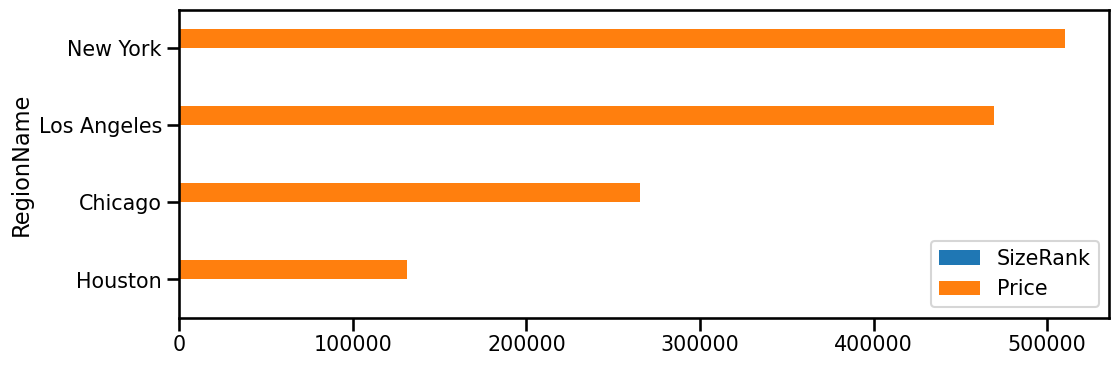

In [14]:
sorted_highValue = highValue.sort_values('Price', ascending=True)
highValue_reset = sorted_highValue.reset_index(level='Date', drop=True)

highValue_reset.plot(kind='barh')

Based on the data, New York had the highest average home value at the end of 2008 510,309, while Chicago looks like it is ranked lower; the lowest average price is actually in Houston 131,283.

# How much did home values change from Nov 2008 - Dec 2008

In [15]:
plot.head()

RegionName,New York,Los Angeles,Houston,Chicago
Date,,,,
2000-01-31,253690.0,234181.0,109068.0,166139.0
2000-02-29,255517.0,234401.0,109079.0,166536.0
2000-03-31,257207.0,235513.0,108878.0,167368.0
2000-04-30,260310.0,237589.0,108881.0,168826.0
2000-05-31,263204.0,240113.0,108834.0,170499.0


In [16]:
changeDec = plot.loc['2008-11-30':'2008-12-31'].diff()

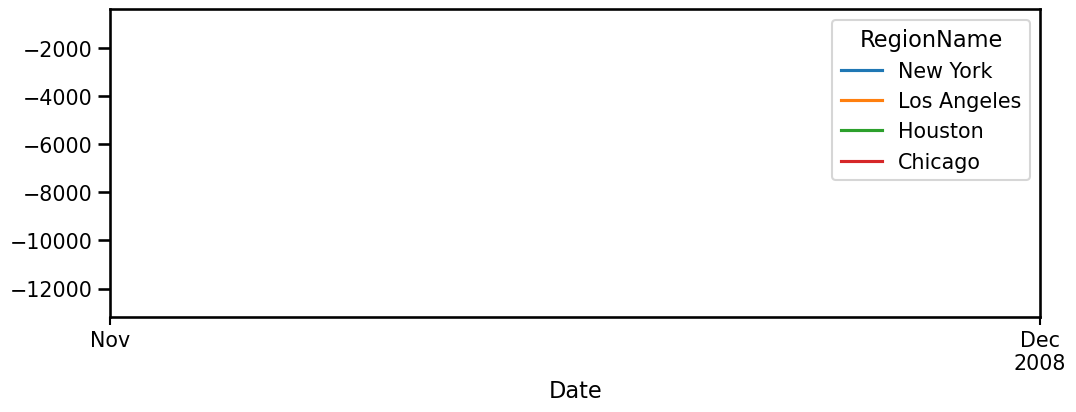

In [17]:
changeDec.plot();

# GridSearch SARIMA

Your overall goal is to forecast the home values for the city with the highest home value in 2008(New York) 6months into the future (beyond the dataset).

In [18]:
tsDF.loc['2018':]

SizeRank RegionName State  \
RegionName Date                                    
Chicago    2000-01-31         3    Chicago    IL   
           2000-02-29         3    Chicago    IL   
           2000-03-31         3    Chicago    IL   
           2000-04-30         3    Chicago    IL   
           2000-05-31         3    Chicago    IL   
...                         ...        ...   ...   
New York   2022-05-31         0   New York    NY   
           2022-06-30         0   New York    NY   
           2022-07-31         0   New York    NY   
           2022-08-31         0   New York    NY   
           2022-09-30         0   New York    NY   

                                                       Metro     CountyName  \
RegionName Date                                                               
Chicago    2000-01-31     Chicago-Naperville-Elgin, IL-IN-WI    Cook County   
           2000-02-29     Chicago-Naperville-Elgin, IL-IN-WI    Cook County   
           2000-03-31     Chicago-Naperville-Elgin, IL-IN-WI    Cook County   
           2000-04-30     Chicago-Naperville-Elgin, IL-IN-WI    Cook County   
           2000-05-31     Chicago-Naperville-Elgin, IL-IN-WI    Cook County   
...                                                      ...            ...   
New York   2022-05-31  New York-Newark-Jersey City, NY-NJ-PA  Queens County   
           2022-06-30  New York-Newark-Jersey City, NY-NJ-PA  Queens County   
           2022-07-31  New York-Newark-Jersey City, NY-NJ-PA  Queens County   
           2022-08-31  New York-Newark-Jersey City, NY-NJ-PA  Queens County   
           2022-09-30  New York-Newark-Jersey City, NY-NJ-PA  Queens County   

                          Price  
RegionName Date                  
Chicago    2000-01-31  166139.0  
           2000-02-29  166536.0  
           2000-03-31  167368.0  
           2000-04-30  168826.0  
           2000-05-31  170499.0  
...                         ...  
New York   2022-05-31  768797.0  
           2022-06-30  773944.0  
           2022-07-31  777692.0  
           2022-08-31  779960.0  
           2022-09-30  781622.0  

[1092 rows x 6 columns]

In [19]:
NY2018plus = tsDF.loc[(tsDF.index.get_level_values('RegionName') == 'New York') & 
                                      (tsDF.index.get_level_values('Date') >= '2018-01-01')]

In [24]:
NY2018plus = NY2018plus.reset_index()
NY2018plus = NY2018plus.set_index('Date').asfreq('M')

In [25]:
NY2018plus = NY2018plus['Price']
NY2018plus.head()

Date
2018-01-31    656700.0
2018-02-28    661012.0
2018-03-31    665672.0
2018-04-30    669989.0
2018-05-31    673514.0
Freq: M, Name: Price, dtype: float64

In [26]:
NY2018plus.isna().sum()

0

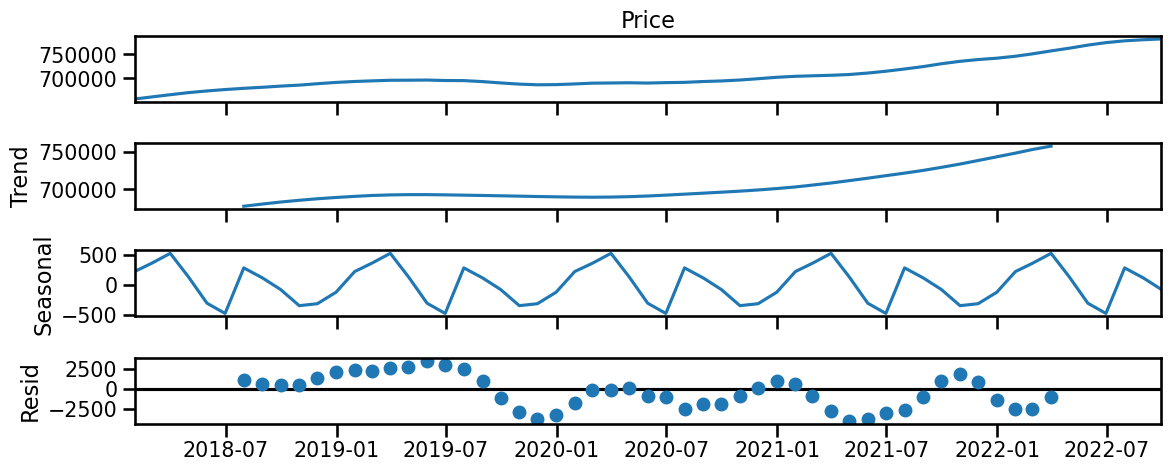

In [27]:
decomp = tsa.seasonal_decompose(NY2018plus)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout();

The data does appear to have a seasonal aspect to it, so we will test it with a SARIMA model.

In [34]:
get_adfuller_results(NY2018plus)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,0.407572,4,52,0.981776,0.05,False


In [38]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(NY2018plus.max()-NY2018plus.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 1006.1319444444575 which is ~0.81% of the variation in time series.


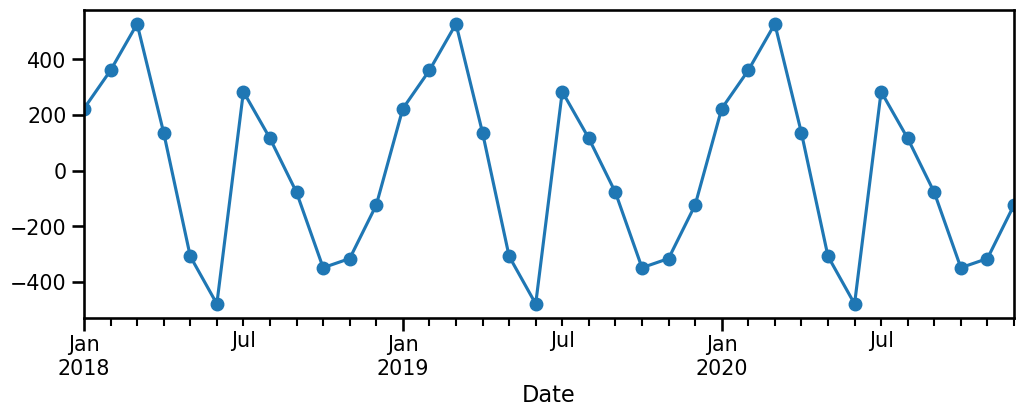

In [39]:
seasonal = decomp.seasonal
ax = seasonal.loc['2018':'2020'].plot(marker='o')

In [40]:
d = ndiffs(NY2018plus)
print(f'd = {d}')
D = nsdiffs(NY2018plus,m=12)
print(f'D = {D}')

d = 2
D = 0


,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-5.461615,2,52,0.000003,0.05,True


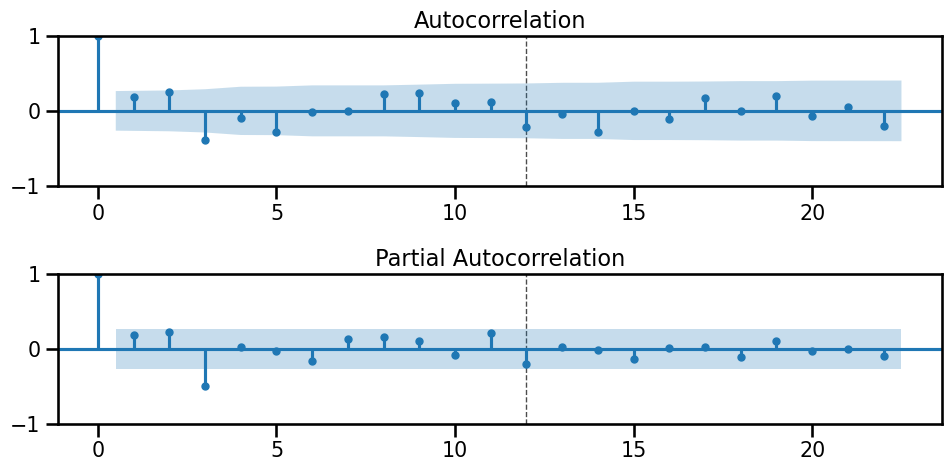

In [43]:
tsDiff = NY2018plus.diff().dropna()
tsDiff2 = tsDiff.diff().dropna()

plot_acf_pacf(tsDiff2,annotate_seas=True,m=12,nlags=22);
get_adfuller_results(tsDiff2)

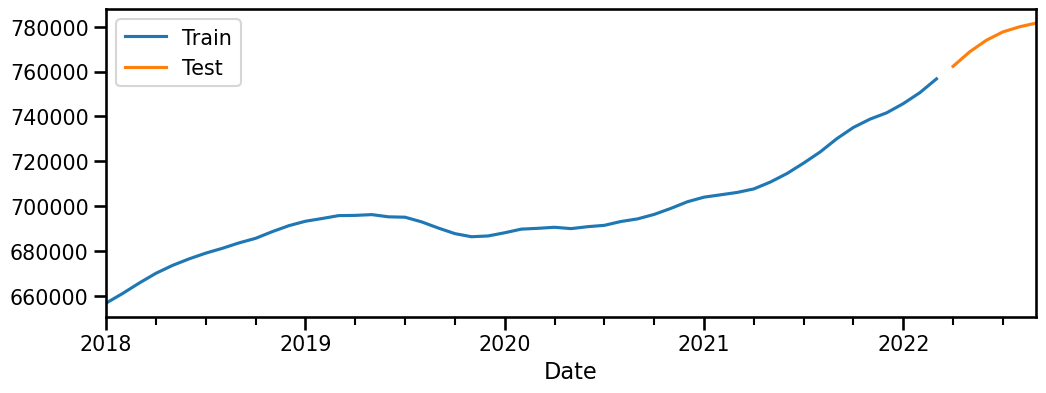

In [56]:
train, test = train_test_split(NY2018plus, test_size=len(test))
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [60]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 2  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()

C:\Users\austi\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                            Price   No. Observations:                   51
Model:             ARIMA(1, 2, 1)x(1, 0, 1, 12)   Log Likelihood                -401.677
Date:                          Wed, 17 Jan 2024   AIC                            813.353
Time:                                  13:25:58   BIC                            822.812
Sample:                              01-31-2018   HQIC                           816.942
                                   - 03-31-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9240      0.177     -5.227      0.000      -1.271      -0.578
ma.L1          0.9230      0.179      5.166      0.000       0.573       1.273
ar.S.L12       0.9295      2.577      0.361      0.718      -4.121       5.979
ma.S.L12      -0.9287      2.581     -0.360      0.719      -5.987       4.130
sigma2      7.509e+05   3.64e-06   2.06e+11      0.000    7.51e+05    7.51e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.60   Jarque-Bera (JB):                 1.79
Prob(Q):                              0.21   Prob(JB):                         0.41
Heteroskedasticity (H):               2.29   Skew:                            -0.04
Prob(H) (two-sided):                  0.11   Kurtosis:                         2.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.76e+29. Standard errors may be unstable.
"""

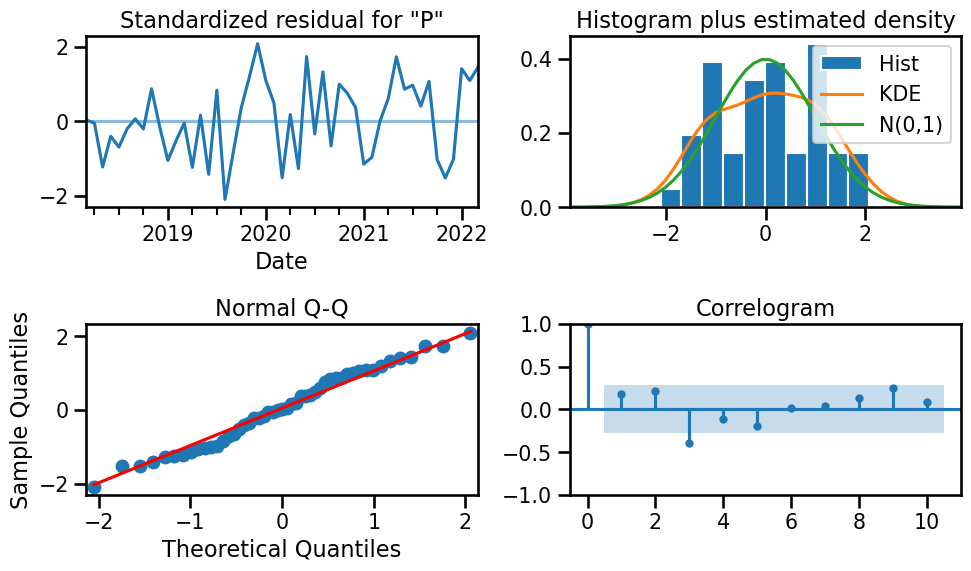

In [62]:
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout();

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 4,205.942
- MSE = 36,065,175.569
- RMSE = 6,005.429
- R^2 = 0.201
- MAPE = 0.54%


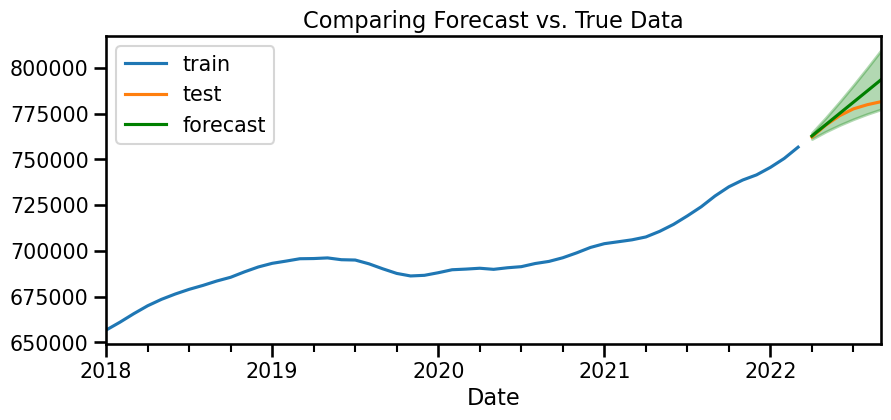

In [63]:
forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
plot_forecast(train, test, forecast_df);
regression_metrics_ts(test, forecast_df['mean'])

In [65]:
import pmdarima as pm

auto_model = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1040.349, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=909.717, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=930.102, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=912.587, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=940.569, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=911.717, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=911.717, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=913.717, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=928.324, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=910.593, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=907.207, Time=0.08 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=909.209, Time=0.19 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1024.876, Time=0.09 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=911.401, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[12] interc

In [66]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 0  # Seasonal AR
D = 0  # Seasonal differencing
Q = 0  # Seasonal MA
m = 12 # Seasonal period

Autosarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
Autosarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                   51
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -452.947
Date:                Wed, 17 Jan 2024   AIC                            911.895
Time:                        13:27:59   BIC                            917.631
Sample:                    01-31-2018   HQIC                           914.079
                         - 03-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.008    129.821      0.000       0.985       1.015
ma.L1         -0.9997      0.086    -11.632      0.000      -1.168      -0.831
sigma2      4.315e+06   5.79e-09   7.45e+14      0.000    4.32e+06    4.32e+06
===================================================================================
Ljung-Box (L1) (Q):                  39.10   Jarque-Bera (JB):                 0.54
Prob(Q):                              0.00   Prob(JB):                         0.77
Heteroskedasticity (H):               2.15   Skew:                            -0.20
Prob(H) (two-sided):                  0.12   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.13e+29. Standard errors may be unstable.
"""

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 10,334.760
- MSE = 119,049,338.701
- RMSE = 10,910.973
- R^2 = -1.639
- MAPE = 1.33%


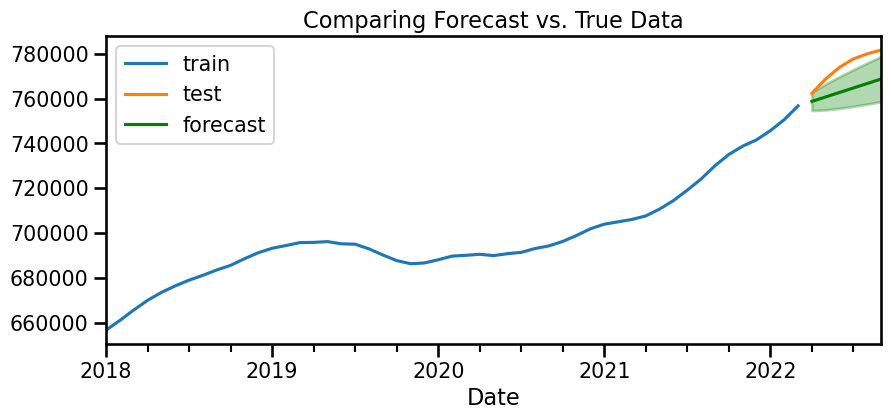

In [67]:
forecast_df = Autosarima.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

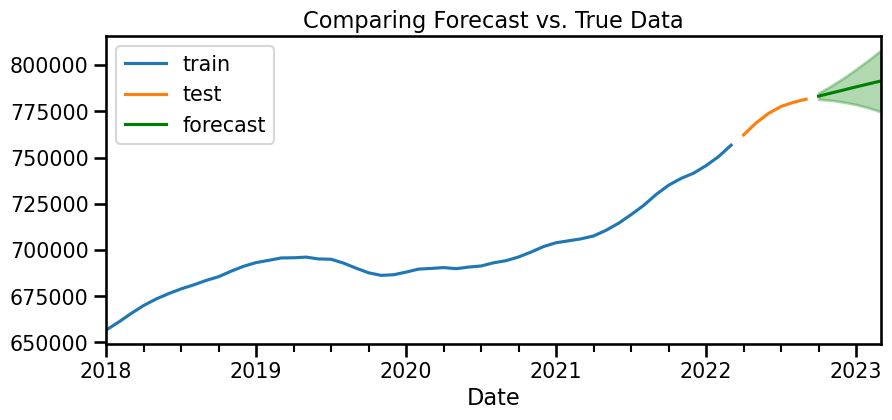

In [69]:
# These are the parameters of our final model
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 2  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

final_model = tsa.ARIMA(NY2018plus, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

forecast_df  = final_model.get_forecast(len(test)).summary_frame()
plot_forecast(train,test,forecast_df);

In [73]:
start = forecast_df['mean'].iloc[0]
end = forecast_df['mean'].iloc[-1]
change = end - start
perChange = (change / start) * 100

print(change, perChange)

8226.1603935936 1.0502305926025473


- What is the predicted home value in New York City 6 months into the future (beyond the dataset?

  * $791,498 is the estimated price in 6 months.
- 
What is the percent change in home values in New York City by the end of the 6-month forecast (beyond the dataset?
  
  * 1.05% home value increase is forecasted.?

In [74]:
end

791497.9915072332